<a href="https://colab.research.google.com/github/andrey-varna/OSR_passport/blob/main/Pet_passport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os  
import cv2
import math
import torch
import keras
import pickle
import warnings
import torchvision
import numpy as np
import pandas as pd
import tensorflow as tf
from google.colab import drive 
from keras.models import load_model
from torch.autograd import Variable
from google.colab.patches import cv2_imshow
from IPython.display import Image, clear_output 

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [1]:
from google.colab import drive                                                  # Подключаю гугл диск
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
class OCR_Model(torch.nn.Module):
    def __init__(self, n_classes=53, out_len=32):
        super().__init__()
        self.m = torchvision.models.resnet34(weights='ResNet34_Weights.DEFAULT')
        self.blocks = [torch.nn.Conv2d(3, 64, 7, 1, 3), self.m.bn1, self.m.relu, self.m.maxpool, 
                      self.m.layer1, self.m.layer2, self.m.layer3]
        self.feature_extractor = torch.nn.Sequential(*self.blocks)
        self.avg_pool = torch.nn.AdaptiveAvgPool2d((512, out_len))
        self.bilstm1 = torch.nn.LSTM(512, 256, 2, dropout=0.15, batch_first=True, bidirectional=True)
        self.bilstm2 = torch.nn.LSTM(512, 256, 2, dropout=0.15, batch_first=True, bidirectional=True)
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(512, 256),
            torch.nn.GELU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(256, n_classes))
        

    def forward(self, x, return_x=False):
        feature = self.feature_extractor(x)
        b, c, h, w = feature.size()
        feature = feature.view(b, c * h, w)
        feature = self.avg_pool(feature)
        feature = feature.transpose(1, 2)
        out, (h_t1, c_t1) = self.bilstm1(feature)
        out, _ = self.bilstm2(out, (h_t1, c_t1))
        out = self.classifier(out)
        
        return out

class Passport():
    
    def __init__(self):
        self.ModelFolder=''                                                     # "OCRModels/"
        self.Model1=load_model(self.ModelFolder+'OCRModels/Model_w740_h64_zeroz1312-740_dropout_numbers_v2.h5', compile=False)
        self.Model2=load_model(self.ModelFolder+'OCRModels/Model_w740_h64_zeroz1312-740_dropout_v2.h5', compile=False)
        self.model_round = torch.hub.load(self.ModelFolder+'yolov5_master', 'custom', path=self.ModelFolder+'yolo5/rotation.pt', source='local')
        self.model_detect = torch.hub.load(self.ModelFolder+'yolov5_master', 'custom', path=self.ModelFolder+'yolo5/detect.pt', source='local')
        self.Model1_2_img_width = 1312                                          # 1148  # 750
        self.Model1_2_img_height = 64                                           # 164   # 64
        self.Model1_3_img_width = 100
        self.Model1_3_img_height = 50
        with open(self.ModelFolder+"OCRModels/characters_letters.pickle", 'rb') as f:
            Model1_2_characters= pickle.load(f)
        char_to_num = keras.layers.StringLookup(vocabulary=list(Model1_2_characters), mask_token=None)
        self.num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)
        self.MaxLenLabel_1_2=80


        self.Model4_short = OCR_Model(out_len=32)
        self.Model4_short.load_state_dict(torch.load(self.ModelFolder+'OCRModels/best_short.pt',map_location=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))) 
        self.Model4_long = OCR_Model(out_len=80)
        self.Model4_long.load_state_dict(torch.load(self.ModelFolder+'OCRModels/best_long.pt',map_location=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')))
        self.char_list = ['№', '’', 'Я', 'Ю', 'Э', 'Ь', 'Ы', 'Ъ', 'Щ', 'Ш', 'Ч', 'Ц', 'Х', 'Ф', 'У', 'Т', 'С', 'Р', 'П', 'О', 'Н', 'М', 'Л', 'К', 'Й', 'И', 'З', 'Ж', 'Е', 'Д', 'Г', 'В', 'Б', 'А', 'Ё', '|', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0', '/', '.', '-', ')', '(', '"']
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
   

    def text2ind(self, text):
        inds = []

        for c in text:
            if c in self.char_list:
                ch = self.char_list.index(c)
            else:
                ch = 0
            inds.append(int(ch))
        return inds

    def inds2text(self, labels):
        string = []

        for lbl in labels:
          string.append(self.char_list[int(lbl)])
        return ''.join(string)

    ''' картинки '''
    def black2white(self, image):
        
        lo=np.array([0,0,0])
        hi=np.array([0,0,0])
        mask = cv2.inRange(image, lo, hi)
        image[mask>0]=(255,255,255)

        return image

    def process_image(self, image, xdim):
      im = self.black2white(image) 
      im = im.astype(np.float32) / 255
      im = cv2.resize(im, (xdim, 64), interpolation=cv2.INTER_LINEAR)           # reshape
      im = np.moveaxis(im, -1, 0)
      X = torch.FloatTensor(im).type(torch.FloatTensor).unsqueeze(0)            # добавить размерность батча
      return X

    ''' функция предикта '''
    def predict_geo(self, image, ocr_model, xdim, delimiter = '|', collapse_repeated=True):
      ocr_model.to(self.device)
      X = self.process_image(image, xdim).to(self.device)  

      with torch.no_grad():
        ocr_model.eval()
        output = torch.nn.functional.log_softmax(ocr_model(X), dim=-1).to(torch.float32)
        arg_maxes = torch.argmax(output, dim=2)
        decodes = []
        for i, args in enumerate(arg_maxes):
            dec = []
            str_out = []

            for j, index in enumerate(args):
                if index != 52:
                    if collapse_repeated and j != 0 and index == args[j -1]:
                        continue
                    dec.append(index.item())

            for d in dec:
              str_out.append(self.char_list[int(d)])     
            decodes.append(''.join(str_out))

        preds =  [tp.replace('|', " ").strip() for tp in decodes]               # fatal!!:))  
        b_greedy_transcript = preds[0]
      
      return b_greedy_transcript

    def get_geo_transcript(self, image,  len_transcript, xdim1 = 256, xdim2 = 640):
        ocr_model1=self.Model4_short
        ocr_model2=self.Model4_long
        
        if len_transcript == 0:
          transcript = self.predict_geo(image, ocr_model1, xdim1)
          len_transcript = len(transcript)
          if len_transcript>=15:
              transcript = self.predict_geo(image, ocr_model2, xdim2)
        
        if len_transcript > 0 and len_transcript <= 15:
          transcript = self.predict_geo(image, ocr_model1, xdim1)
        else:
          transcript = self.predict_geo(image, ocr_model2, xdim2)
        
        return transcript

    def encode_mw(self,img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (self.Model1_3_img_width, self.Model1_3_img_height), cv2.INTER_NEAREST)
        img1 = np.array(img)
        img1 = img1.reshape(img1.shape[0],img1.shape[1],1)
        prd=self.Model3.predict(img1)
  
        self.Model1_2_
    
    def encode_single_sample(self,img,ConvertionType=0):                        # type1=0 - Numbers  type=1 - Text

        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.expand_dims(img,axis=-1)
	
        img1 = img.copy()
        img1 = tf.image.convert_image_dtype(img1, tf.float32)
        img1 = tf.image.resize(img1, [self.Model1_2_img_height, 740])
        ones = tf.ones((self.Model1_2_img_height, (self.Model1_2_img_width - 740), 1), dtype=tf.float32)
        img1 = tf.concat([img1, ones], 1)
        img1 = tf.transpose(img1, perm=[1, 0, 2])
        
        if(ConvertionType==0):
            Prediction=self.Model1.predict(np.expand_dims(img1,0),verbose=0)    # np.expand_dims(ImArr,0)
        elif(ConvertionType==1):
            Prediction=self.Model2.predict(np.expand_dims(img1,0),verbose=0)
			
        input_len = np.ones(Prediction.shape[0]) * Prediction.shape[1]

        results = keras.backend.ctc_decode(Prediction, input_length=input_len, greedy=True)[0][0][:,:self.MaxLenLabel_1_2]
        output_text=tf.strings.reduce_join(self.num_to_char(results[0])).numpy().decode("utf-8")
        output_text=output_text.replace("[UNK]","")

        BreaksEnd=False
        BreaksEndPos=0
        for i in range(-1,-len(output_text),-1):
            if(output_text[i]!=" " and BreaksEndPos==0):
                BreaksEnd=True
                BreaksEndPos=i
                break
        if(BreaksEndPos<-1):
            output_text=output_text[:BreaksEndPos+1]
        return output_text
		
		
    def zero(self,n):
        return n * (n > 0)

    def rotate_image(self, mat, angle):
        height, width = mat.shape[:2]
        image_center = (width / 2, height / 2)
        rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)
        abs_cos = abs(rotation_mat[0, 0])
        abs_sin = abs(rotation_mat[0, 1])
        bound_w = int(height * abs_sin + width * abs_cos)
        bound_h = int(height * abs_cos + width * abs_sin)
        rotation_mat[0, 2] += bound_w / 2 - image_center[0]
        rotation_mat[1, 2] += bound_h / 2 - image_center[1]
        return cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))

    def get_angle_rotation(self, centre, point, target_angle):
        new_point =(point[0] - centre[0], point[1] - centre[1])
        a,b = new_point[0], new_point[1]
        res = math.atan2(b,a)
        if (res < 0) :
              res += 2 * math.pi
        return (math.degrees(res)+target_angle) % 360

    def result(self,img):
        return self.model_round(img)

    def get_image_after_rotation(self, img):
        results = self.result(img)
        pd = results.pandas().xyxy[0]
        pd = pd.assign(centre_x = pd.xmin + (pd.xmax-pd.xmin)/2)
        pd = pd.assign(centre_y = pd.ymin + (pd.ymax-pd.ymin)/2)
        tmp = pd.loc[pd['name']=='niz']
        N, V = None, None
        for index, row in tmp.iterrows():
            N = (row['centre_x'], row['centre_y'])
            break
        tmp = pd.loc[pd['name']=='verh']
        for index, row in tmp.iterrows():
            V = (row['centre_x'], row['centre_y'])
            break
        if N == None or V == None:
            return img

        angle = self.get_angle_rotation(N, V, 90)
        img = self.rotate_image(img, angle)
        return img

    def crop_img(self, img):
        results = self.result(img)
        pd = results.pandas().xyxy[0]
        x1 =int(pd.xmin.min())
        x2 = int(pd.xmax.max())
        y1 = int(pd.ymin.min())
        y2 = int(pd.ymax.max())
        img = img[y1:y2,x1:x2]
        return img

    def get_crop(self,file):
        image = cv2.imread(file)
        ''' перевожу в оттенки серого '''
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ''' поворот в нормальный вид с помощью первой yolo '''
        image = gray.copy()
        image = self.get_image_after_rotation(image)
        image = self.get_image_after_rotation(image)
        ''' обрезка картинки '''
        image = self.crop_img(image)
        #image = Image.fromarray(image)                                         # массив в изображение           
        #im2 = Image.fromarray(image).show()                                    # для вывода на экран - добавляем .show()
        #im2.save('/content/drive/MyDrive/AI/Diplom/Photo/фото_400.png', quality=100) # сохраняю новое изображение, если надо
        return image

    def yolo_5(self, img):
        results = self.model_detect(img)
        df = results.pandas().xyxy[0]
        df = df.drop(np.where(df['confidence'] < 0.7)[0])
        ob = pd.DataFrame()
        ob['class'] = df['name']
        ob['x'] = df['xmin']
        ob['y'] = df['ymin']
        ob['w'] = df['xmax']-df['xmin']
        ob['h'] = df['ymax']-df['ymin']
        oblasty = ob.values.tolist()
        return img, oblasty

    def oblasty_yolo_5(self, image, box):
        oblasty = {}
        iss = 0
        plac = 0
        spissok = sorted(box, reverse=False, key=lambda x: x[2])
        for l in spissok:
            cat = l[0]
            y = int(l[2])
            x = int(l[1])
            h = int(l[4])
            w = int(l[3])
            ob = ''
            if ('signature' in cat) or ('photograph' in cat):
                pass
            else:
                if 'issued_by_whom' in cat:
                    ob = cat + '_' + str(iss)
                    iss += 1
                elif 'place_of_birth' in cat:
                    ob = cat + '_' + str(plac)
                    plac += 1
                elif 'series' not in cat:
                    ob = cat
                if ob:
                    oblasty[ob] = image[self.zero(y - math.ceil(h * 0.07)):y + math.ceil(h * 1.1),
                                  self.zero(x - math.ceil(w * 0.1)):x + math.ceil(w * 1.1)]
                if 'series' in cat:
                    ob = cat
                    cropped = image[self.zero(y - math.ceil(h * 0.1)):y + math.ceil(h * 1.1),
                              self.zero(x - math.ceil(w * 0.03)):x + math.ceil(w * 1.03)]
                    oblasty[ob] = cv2.rotate(cropped, cv2.ROTATE_90_COUNTERCLOCKWISE) # self.rotate_image(cropped, 90)
        return oblasty

    def recognition_slovar(self, oblasty):
        data = {}
        data['pasport'] = []
        d = {}
        issued_by_whom = ''
        series_and_number = ''
        place_of_birth = ''
        ver = 0
        for i, v in oblasty.items():
            image = cv2.cvtColor(v, cv2.COLOR_BGR2RGB)
            if 'date' in i:
                result = self.encode_single_sample(image, ConvertionType=0)

            elif 'code' in i:
                result = self.encode_single_sample(image, ConvertionType=0)

            elif 'series' in i:
                result = self.encode_single_sample(image, ConvertionType=0)

            elif 'surname' in i or 'name' in i or 'patronymic' in i:
                len_transcript = 0
                result = self.get_geo_transcript(image, len_transcript)
                           
            elif 'issued_by_whom' in i:
                len_result = self.encode_single_sample(image, ConvertionType=1)
                len_transcript = len(len_result)
                result = self.get_geo_transcript(image, len_transcript)

            elif 'place_of_birth' in i:
                len_transcript = 0
                result = self.get_geo_transcript(image, len_transcript)

            elif 'gender' in i:
                result = self.encode_single_sample(image, ConvertionType=1)

                                                    
            else:
                result = self.encode_single_sample(image,ConvertionType=1)
            pole = result                                                       # ''
  
            if pole:
                pole = pole.strip()
                if 'issued_by_whom' in i:
                    issued_by_whom = issued_by_whom + pole + ' '
                if 'place_of_birth' in i:
                    place_of_birth = place_of_birth + pole + ' '
                if 'series_and_number' in i:
                    """
                    if len(pole) >= 10:
                        if ver < result[k][2]:
                            series_and_number = pole
                    """
                    series_and_number = pole
                    
                if 'issued_by_whom' in i or 'place_of_birth' in i or 'series_and_number' in i:
                    pass
                elif 'date' in i:
                    pole = pole.replace('.', '').replace(' ', '').replace('-', '')
                    pole = pole[:2] + '.' + pole[2:4] + '.' + pole[4:8]
                    d[i.split('.', 1)[0]] = pole.upper().strip()

                elif 'cod' in i:
                    pole = pole.replace(' . ', '').replace(' ', '').replace('-', '')
                    pole = pole[:3] + '-' + pole[3:6]
                    d[i.split('.', 1)[0]] = pole.upper().strip()

                elif 'gender' in i:
                    pole1 = ''
                    if 'Е' in pole.upper() or 'Н' in pole.upper() or 'ЕН' in pole.upper():
                        pole1 = 'ЖЕН.'
                    if 'У' in pole.upper() or 'М' in pole.upper() or 'УЖ' in pole.upper():
                        pole1 = 'МУЖ.'
                    pole = pole1
                    d[i.split('.', 1)[0]] = pole.upper().strip()

                else:
                    d[i.split('.', 1)[0]] = pole.replace('  ', ' ').upper().strip()

        place_of_birth = place_of_birth.upper()
        issued_by_whom = issued_by_whom.upper()
        
        if place_of_birth[:2] == 'C ':
            place_of_birth = place_of_birth.replace('С ', ' С. ')

        if issued_by_whom[:2] == 'C ':
            issued_by_whom = issued_by_whom.replace('С ', ' С. ')

        place_of_birth = place_of_birth.replace('ГОР ', 'ГОР. ')\
                                        .replace(' С ', ' С. ')\
                                        .replace(' Г ', ' Г. ')\
                                        .replace('ОБЛ ', 'ОБЛ. ')\
                                        .replace('ПОС ', 'ПОС. ')\
                                        .replace('ДЕР ', 'ДЕР. ')\
                                        .replace(' . ', '. ')\
                                        .replace(' .', '.')\
                                        .replace('  ', ' ')\
                                        .replace('..', '.')\
                                        .replace('.', '. ')\
                                        .replace('  ', ' ')\
                                        .replace('--', '-')

        issued_by_whom = issued_by_whom.replace('ГОР ', 'ГОР. ')\
                                        .replace(' С ', ' С. ')\
                                        .replace(' Г ', ' Г. ')\
                                        .replace('ОБЛ ', 'ОБЛ. ')\
                                        .replace('ПОС ', 'ПОС. ')\
                                        .replace('ДЕР ', 'ДЕР. ')\
                                        .replace(' . ', '. ')\
                                        .replace(' .', '.')\
                                        .replace('  ', ' ')\
                                        .replace('..', '.')\
                                        .replace('.', '. ')\
                                        .replace('  ', ' ')\
                                        .replace('--', '-')
        if series_and_number:
            series_and_number = series_and_number.replace(' ', '')
            if len(series_and_number) == 10:
                series_and_number = series_and_number[:2] + ' ' + series_and_number[2:4] + ' ' + series_and_number[4:10]

            else:
                series_and_number = 'поле распознано не полностью' + series_and_number

        else:
            series_and_number = ''
        d['issued_by_whom'] = issued_by_whom.strip()
        d['place_of_birth'] = place_of_birth.strip()
        d['series_and_number'] = series_and_number.strip()
        data['pasport'].append(d)

        return data['pasport']

    def detect_passport(self,photo):
        pole = ['date_of_birth','date_of_issue','first_name','gender','issued_by_whom',
                'patronymic','place_of_birth','series_and_number','surname','unit_code']

        croped = self.get_crop(photo)
        if croped != '':
            img, detect = self.yolo_5(croped)
            obl = self.oblasty_yolo_5(img, detect)
            rec = self.recognition_slovar(obl)
            key = list(rec[0].keys())
            value = list(rec[0].values())

            if set(key) == set(pole):
                if '' in value:
                    flag = 1

                else:
                    flag = 0
                    if len(rec[0]['date_of_birth']) != 10 or len(rec[0]['date_of_issue']) != 10 or len(rec[0]['series_and_number']) != 12 or len(rec[0]['unit_code']) != 7:
                        flag = 1
            else:
                flag = 1

            if flag == 1:
                rec =rec[0]# {}
            else:
                rec = rec[0]
            return rec, flag
        else:
            return {}, 1

     

In [10]:
!cp -R /content/drive/MyDrive/Pet_passport/yolo5 yolo5
!cp -R /content/drive/MyDrive/Pet_passport/yolov5_master yolov5_master
!cp -R /content/drive/MyDrive/Pet_passport/OCRModels OCRModels

In [11]:
psprt = Passport()

YOLOv5 🚀 2023-5-6 Python-3.10.11 torch-2.0.0+cu118 CPU

Fusing layers... 
Model summary: 290 layers, 20856975 parameters, 0 gradients
Adding AutoShape... 
YOLOv5 🚀 2023-5-6 Python-3.10.11 torch-2.0.0+cu118 CPU

Fusing layers... 
Model summary: 322 layers, 86254162 parameters, 0 gradients
Adding AutoShape... 


In [12]:
!unzip /content/drive/MyDrive/Pet_passport/test_pass1.zip
clear_output()

In [13]:
folder_path = '/content/test_pass1'
results=[]
for file_name in os.listdir(folder_path):
    if file_name.endswith('.jpeg'):
        file_path = os.path.join(folder_path, file_name)
        data1=psprt.detect_passport(file_path)
        results.append((file_name, data1))

In [14]:
df_data = []
for tup in results:
    row_dict = {}
    row_dict['file_name'] = tup[0]
    for k, v in tup[1][0].items():
        row_dict[k] = v
    df_data.append(row_dict)
df1 = pd.DataFrame(df_data)
df1 = df1.sort_values(by='file_name').reset_index(drop=True)
df1['issued_by_whom'] = df1['issued_by_whom'].astype(str)
df1['issued_by_whom'] = df1['issued_by_whom'].str.strip()
df1['place_of_birth'] = df1['place_of_birth'].astype(str)
df1['place_of_birth'] = df1['place_of_birth'].str.strip()
df1['gender'] = df1['gender'].astype(str)
df1['gender'] = df1['gender'].str.strip()

In [15]:
df = pd.read_excel('/content/test_pass1/test_pass_labels.xlsx', na_filter=False)
df.fillna('', inplace=True)
df['issued_by_whom'] = df['issued_by_whom_0'].apply(lambda x: str(x)) + ' ' + df['issued_by_whom_1'].apply(lambda x: str(x)) + ' ' + df['issued_by_whom_2'].apply(lambda x: str(x))

df['place_of_birth'] = df['place_of_birth_0'].apply(lambda x: str(x)) + ' ' + df['place_of_birth_1'].apply(lambda x: str(x)) + ' ' + df['place_of_birth_2'].apply(lambda x: str(x))
df.rename(columns={'series_and_number_1': 'series_and_number'}, inplace=True)
df2 = df.drop(columns=['issued_by_whom_0', 'issued_by_whom_1', 'issued_by_whom_2', 'place_of_birth_0', 'place_of_birth_1', 'place_of_birth_2', 'series_and_number_2'])

In [16]:
df3 = df2.reindex(columns=df1.columns)
df3 = df3.sort_values(by='file_name').reset_index(drop=True)
df3['issued_by_whom'] = df3['issued_by_whom'].astype(str)
df3['issued_by_whom'] = df3['issued_by_whom'].str.strip()
df3['place_of_birth'] = df3['place_of_birth'].astype(str)
df3['place_of_birth'] = df3['place_of_birth'].str.strip()
df3['patronymic'] = df3['patronymic'].str.strip()
df3['gender'] = df3['gender'].astype(str)
df3['gender'] = df3['gender'].str.strip()

### Итоговая таблица

In [17]:
df4 = df1.eq(df3)
df4 = df4.replace({True: 1, False: 0})
df4 = df4.astype(int)
df4['%'] = df4.iloc[:, 1:].sum(axis=1)/10*100
sum_row = pd.DataFrame(df4.iloc[:, :-1].sum()).T/16*100
sum_row.columns = df4.columns[:-1]
df4 = df4.append(sum_row, ignore_index=True)
pd.set_option('display.max_columns', None)
df4

,file_name,unit_code,date_of_issue,surname,first_name,patronymic,date_of_birth,gender,issued_by_whom,place_of_birth,series_and_number,%
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,100.0
1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,90.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,100.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.00,0.00,90.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,100.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,100.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,100.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,100.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.00,1.00,1.00,90.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,100.0


In [18]:
len(df4[df4['%']==100.0])

11

In [19]:
rows, cols = np.where(df4 == 0)
# Вывод значений ячеек с ошибками
for row, col in zip(rows, cols):
    file_name = df1.iloc[row, 0]                                                # Имя файла берем из первого столбца
    print(f'File name: {file_name}', f'Row: {row}, Column: {col}', f'df1 value: {df1.iloc[row, col]}', f'df3 value: {df3.iloc[row, col]}')
    

File name: 177de6d27597c51ac801fe8bab8e0931.jpeg Row: 1, Column: 2 df1 value: 73.01.2012 df3 value: 13.01.2012
File name: 3710bc70ed198d96abb3f7e8e373276c.jpeg Row: 3, Column: 10 df1 value: поле распознано не полностью46024527213 df3 value: 46 02 527213
File name: 7d8c2607-7bd0-47c9-8011-e035a6f34dd4.jpeg Row: 8, Column: 8 df1 value: ТП №1 ОТДЕЛА УФМС РОССИИ ПО АДМИРАЛТЕЙСКОМ Р-НЕ ГОР. САНКТ-ПЕТЕРБУРГА df3 value: ТП №1 ОТДЕЛА УФМС РОССИИ ПО САНКТ-ПЕТЕРБУРГУ И ЛЕНИНГРАДСКОЙ ОБЛ. В АДМИРАЛТЕЙСКОМ Р-НЕ ГОР. САНКТ-ПЕТЕРБУРГА
File name: c10be491ce2c9f2a29747b88ad232b08.jpeg Row: 11, Column: 9 df1 value: ВМ ГОРОД МОСКВА df3 value: ГОРОД МОСКВА
File name: cd1a4c7f2919a97344c6842fd217e437.jpeg Row: 13, Column: 2 df1 value: 08.05.2012 df3 value: 08.05.2019


### Примеры

Пример некачественного документа:


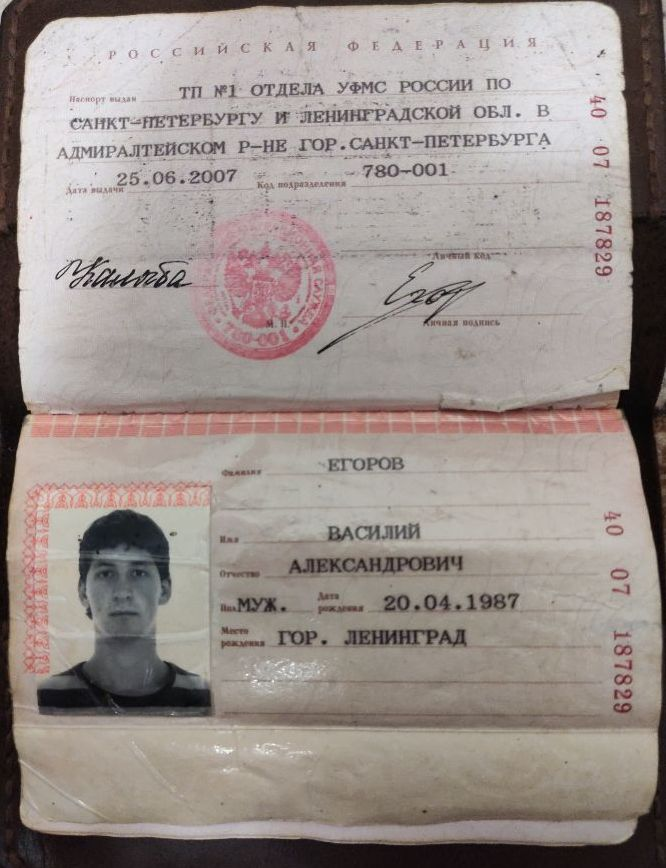


Результат распознавания:
unit_code: 780-001
date_of_issue: 25.06.2007
surname: ЕГОРОВ
first_name: ВАСИЛИЙ
patronymic: АЛЕКСАНДРОВИЧ
date_of_birth: 20.04.1987
gender: МУЖ.
issued_by_whom: ТП №1 ОТДЕЛА УФМС РОССИИ ПО АДМИРАЛТЕЙСКОМ Р-НЕ ГОР. САНКТ-ПЕТЕРБУРГА
place_of_birth: ГОР. ЛЕНИНГРАД
series_and_number: 40 07 187829


In [20]:
bad_pic = '/content/test_pass1/7d8c2607-7bd0-47c9-8011-e035a6f34dd4.jpeg'
image = cv2.imread(bad_pic)

print("Пример некачественного документа:")
cv2_imshow(image)
print()
print("Результат распознавания:")
for k in df4.keys()[1:-1]:
  res = df1[df1['file_name']=='7d8c2607-7bd0-47c9-8011-e035a6f34dd4.jpeg'][k].to_numpy()[0]
  print(k+":", res)

Пример качественного документа:


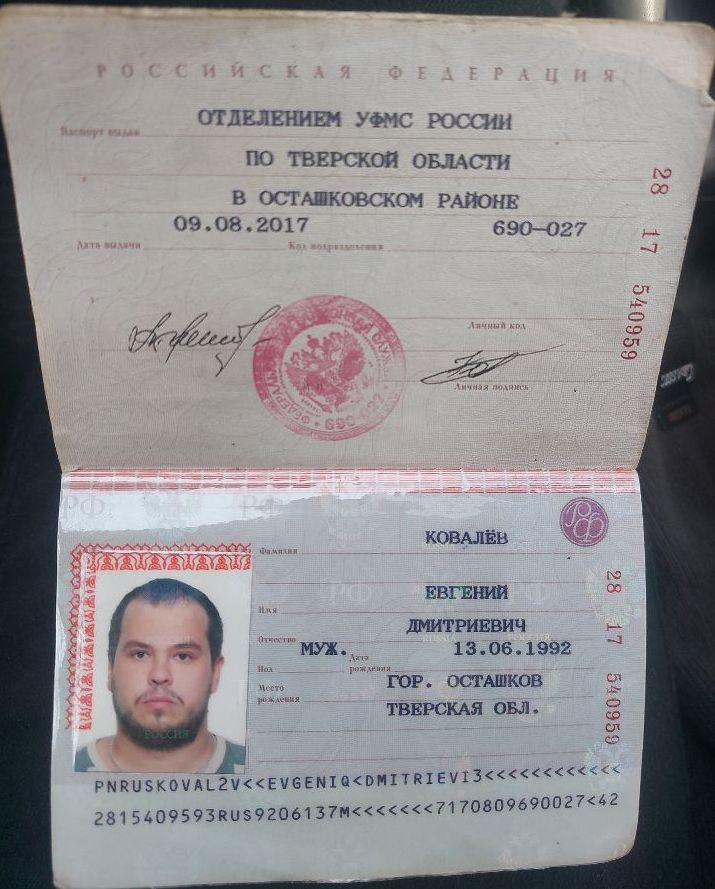


Результат распознавания:
unit_code: 690-027
date_of_issue: 09.08.2017
surname: КОВАЛЁВ
first_name: ЕВГЕНИЙ
patronymic: ДМИТРИЕВИЧ
date_of_birth: 13.06.1992
gender: МУЖ.
issued_by_whom: ОТДЕЛЕНИЕМ УФМС РОССИИ ПО ТВЕРСКОЙ ОБЛАСТИ В ОСТАШКОВСКОМ РАЙОНЕ
place_of_birth: ГОР. ОСТАШКОВ ТВЕРСКАЯ ОБЛ.
series_and_number: 28 17 540959
Все поля распознаны верно!


In [21]:
good_pic = '/content/test_pass1/de6102e3-2a98-4898-90b2-18f30ba3e912.jpeg'
image = cv2.imread(good_pic)
print("Пример качественного документа:")
cv2_imshow(image)

print()
print("Результат распознавания:")
for k in df4.keys()[1:-1]:
  res = df1[df1['file_name']=='de6102e3-2a98-4898-90b2-18f30ba3e912.jpeg'][k].to_numpy()[0]
  print(k+":", res)
print("Все поля распознаны верно!")

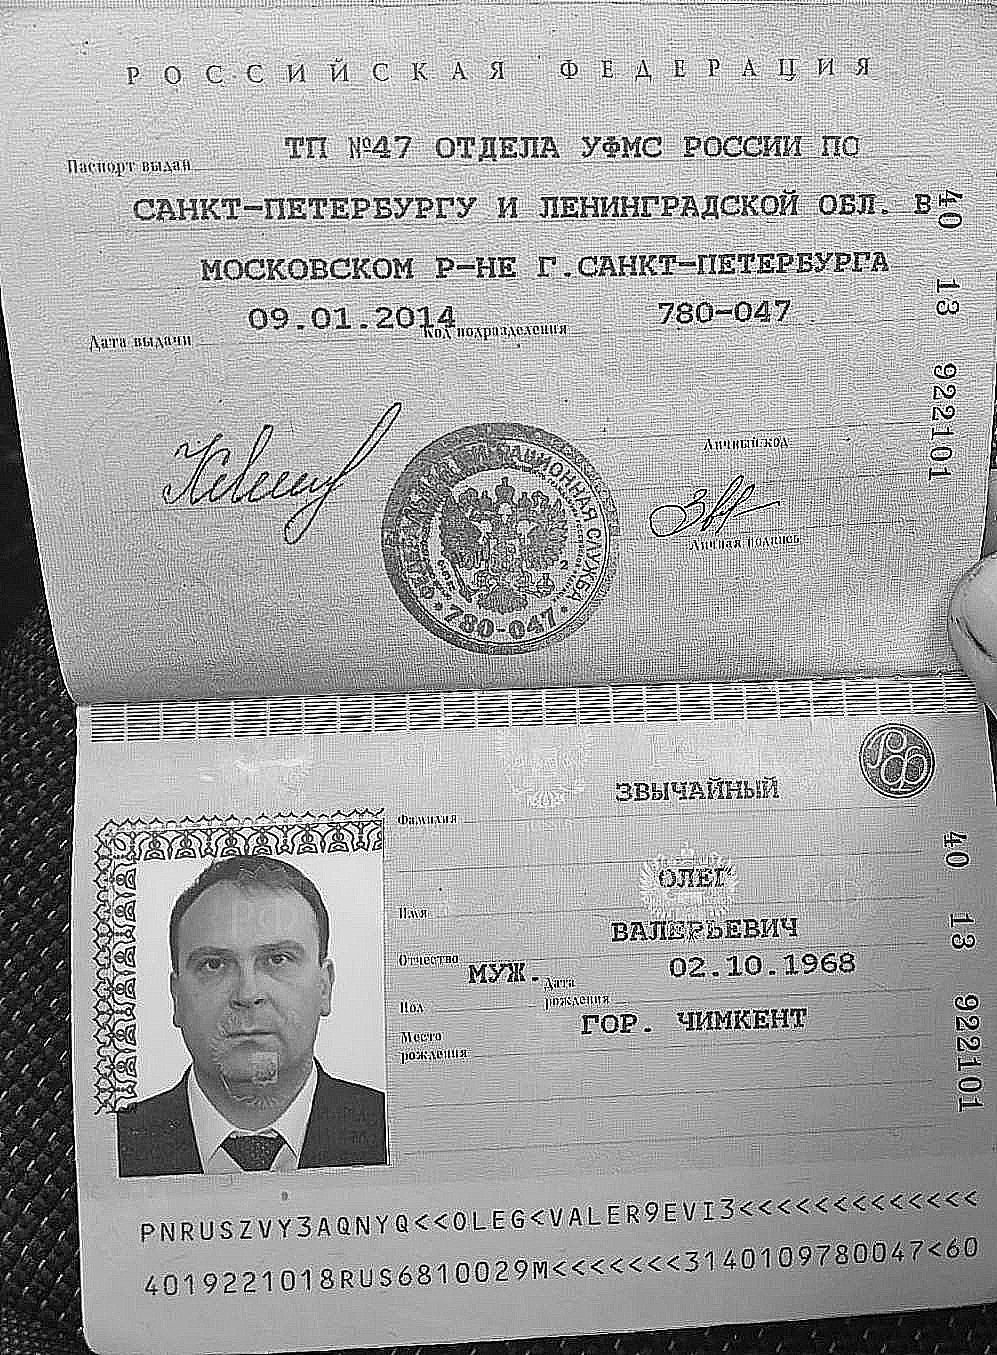

AttributeError: ignored

In [ ]:
from google.colab.patches import cv2_imshow
def get_crop(file):
    image = cv2.imread(file)

    # Создание фильтра для увеличения резкости изображения
    sharp_filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

    # Применение фильтра для увеличения резкости
    image_sharp = cv2.filter2D(image, -1, sharp_filter)

    # Создание маски для удаления засветки
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)[1]

    # Преобразование маски в формат 8-битного одноканального изображения
    mask = cv2.convertScaleAbs(mask)

    # Удаление засветки с помощью функции cv2.inpaint
    removed = cv2.inpaint(image_sharp, mask, 5, cv2.INPAINT_TELEA)

    # Отображение результатов
    #cv2.imshow('Original Image', image)
    #cv2.imshow('Sharpened Image', image_sharp)
    #cv2.imshow('Mask', mask)
    #cv2.imshow('Removed', removed)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    
    ''' перевожу в оттенки серого '''
    gray = cv2.cvtColor(removed, cv2.COLOR_BGR2GRAY)
    
    cv2_imshow(gray)                                              # массив в изображение
           
    #im2 = Image.fromarray(image).show()                                        # для вывода на экран - добавляем .show()
                                           
    im2 = Image.fromarray(gray).show()
    #im2.save('/content/drive/MyDrive/AI/Diplom/Photo/фото_400.png', quality=100) # сохраняю новое изображение, если надо
  #  return image

get_crop('/content/gdrive/MyDrive/AI/Proekts/pasport/test_pass_passport/test_pass/fb4638fde70c26abcfbaac6b09db6db3.jpeg')    #             запуск предобработки